# Sensitivity to outliers

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
import yfinance as yfin
import datetime
plt.rcParams["figure.figsize"] = (12, 9)

In [ ]:
# Download the dataset
end = datetime.date(2024, 1, 1)
start = datetime.date(2014, 1, 1)
prices = pd.DataFrame(
    yfin.download(['SPY', 'NVDA'],
                  start=start, end=end, interval='1wk'
                  )["Adj Close"])
prices.index = prices.index.date
data_set = prices.pct_change().dropna() # compute returns

Next, we run OLS to the model: SPY ~ NVDA.

In [ ]:
# Linear regression result
result = smf.ols(
    "SPY ~ NVDA", data=data_set
).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     294.2
Date:                Sat, 23 Nov 2024   Prob (F-statistic):           1.40e-52
Time:                        23:57:26   Log-Likelihood:                 1384.0
No. Observations:                 521   AIC:                            -2764.
Df Residuals:                     519   BIC:                            -2755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.867e-05      0.001      0.130      0.896      -0.001       0.002
NVDA           0.2034      0.012     17.154      0.000       0.180       0.227
==============================================================================
Omnibus:                      103.599   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.456
Skew:                          -0.846   Prob(JB):                     1.22e-89
Kurtosis:                       7.000   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the coefficient of NVDA is statiscally significant. This suggests a linear relationship between the two variables. In order to confirm the result, we plot the scatter plot and the regression line. This will also help us detect any outliers.

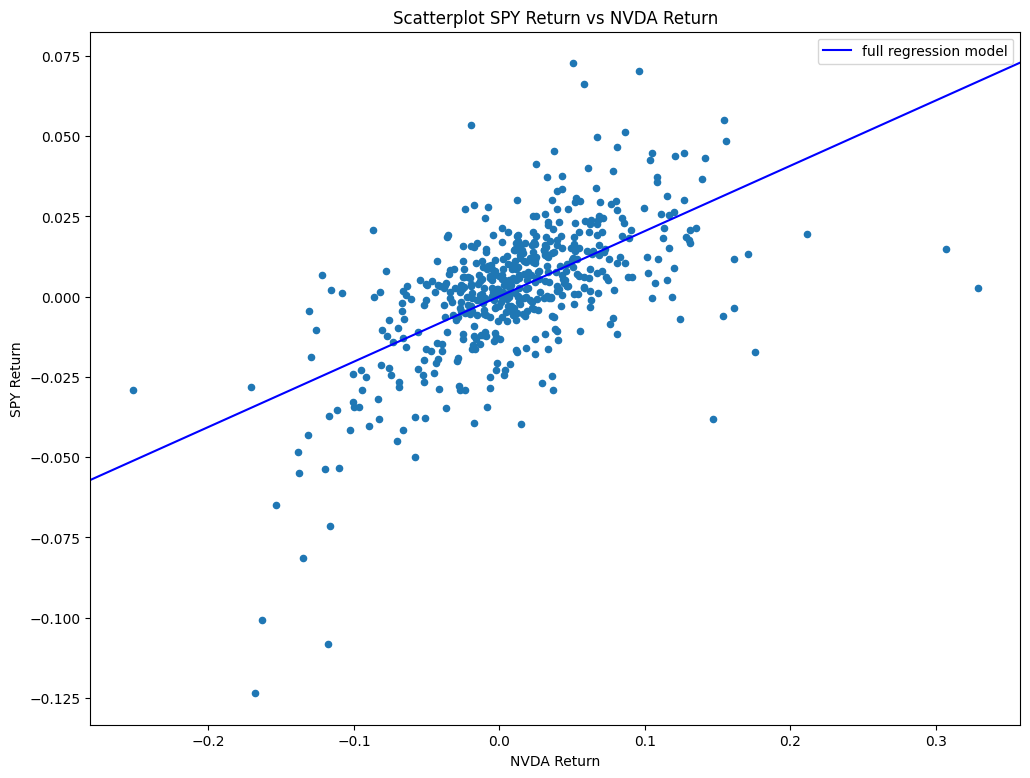

In [ ]:
scatt = data_set.plot.scatter(
    x="NVDA",
    y="SPY",
    title="Scatterplot SPY Return vs NVDA Return",
)
scatt.set(xlabel="NVDA Return", ylabel="SPY Return")

abline_plot(model_results=result, ax=scatt, color="blue", label="full regression model")
plt.legend()
plt.show()

We clearly see from the plot that outliers exist. The goal is to check whether those outliers is influential points or not.

For that reason, we use Cook's distance to detect these outliers.

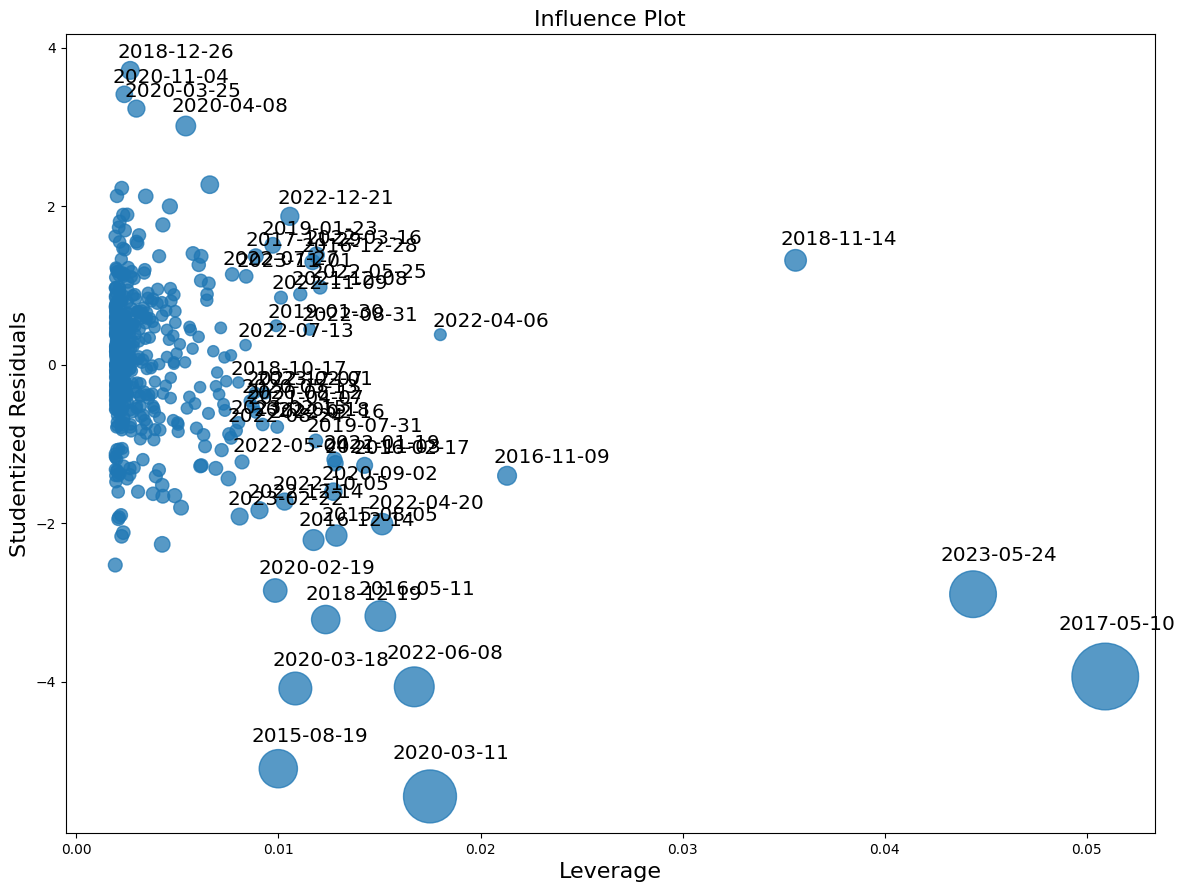

In [ ]:
# Influence plot
fig = sm.graphics.influence_plot(result, criterion="cooks", alpha=0.01)
fig.tight_layout(pad=1.0)

In the plot, the Cook's distance is depicted by the size of a point.

To list out potential influential points, we list 5 most influential points.

In [ ]:
# Finding most influential points
influence = result.get_influence()
inf_pts = influence.summary_frame().sort_values("cooks_d", ascending=False)
inf_pts = inf_pts.head(5)
inf_pts

,dfb_Intercept,dfb_NVDA,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
2017-05-10,-0.015433,-0.894150,0.404131,-3.881461,0.050917,-0.899034,-3.935257,-0.911495
2020-03-11,-0.358773,0.686089,0.250509,-5.303580,0.017500,-0.707826,-5.448160,-0.727121
2023-05-24,-0.019373,-0.610542,0.192072,-2.876210,0.044375,-0.619793,-2.896615,-0.624190
2022-06-08,-0.265300,0.498781,0.136439,-4.005784,0.016721,-0.522378,-4.065260,-0.530134
2015-08-19,-0.302662,0.460439,0.125172,-4.979955,0.009994,-0.500344,-5.098458,-0.512250


We then run a regression without the 5 most influential points to see if we get a better regression line.

In [ ]:
# Linear regression result without the influential point
inf_indices = inf_pts.index
result2 = smf.ols(
    "SPY ~ NVDA", data=data_set.drop(inf_indices)
).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     300.7
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           2.22e-53
Time:                        00:01:07   Log-Likelihood:                 1418.0
No. Observations:                 516   AIC:                            -2832.
Df Residuals:                     514   BIC:                            -2823.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.001      1.163      0.245      -0.001       0.002
NVDA           0.2012      0.012     17.342      0.000       0.178       0.224
==============================================================================
Omnibus:                       30.060   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.892
Skew:                          -0.214   Prob(JB):                     1.00e-18
Kurtosis:                       4.916   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

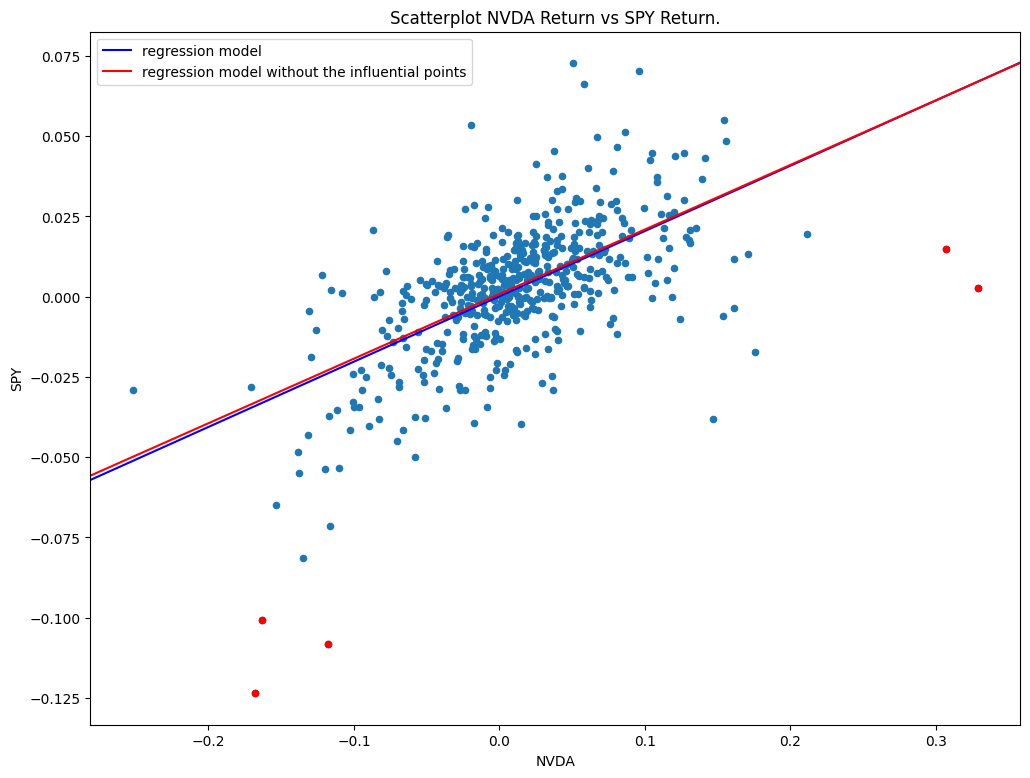

In [ ]:
## Create scatter plot with most influential points
scatt = data_set.plot.scatter(
    x="NVDA",
    y="SPY",
    title="Scatterplot NVDA Return vs SPY Return.",
)
scatt.set(xlabel="NVDA Return", ylabel="SPY Return")
data_set.loc[inf_indices].plot.scatter(x="NVDA", y="SPY", color="red", ax=scatt)

# plot regression lines
abline_plot(model_results=result, ax=scatt, color="blue", label="regression model")
abline_plot(model_results=result2, ax=scatt, color="red", label="regression model without the influential points")

plt.legend()
plt.show()

We see that the two regression lines are almost the same. This means our five most influential points are indeed *not influential*. This can be confirmed by their Cook's distances, which are all below 0.5. (The highest value is only 0.40.)

In [ ]:
inf_pts

,dfb_Intercept,dfb_NVDA,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
2017-05-10,-0.015433,-0.894150,0.404131,-3.881461,0.050917,-0.899034,-3.935257,-0.911495
2020-03-11,-0.358773,0.686089,0.250509,-5.303580,0.017500,-0.707826,-5.448160,-0.727121
2023-05-24,-0.019373,-0.610542,0.192072,-2.876210,0.044375,-0.619793,-2.896615,-0.624190
2022-06-08,-0.265300,0.498781,0.136439,-4.005784,0.016721,-0.522378,-4.065260,-0.530134
2015-08-19,-0.302662,0.460439,0.125172,-4.979955,0.009994,-0.500344,-5.098458,-0.512250


# skewness

Loading libraries and data

---

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the Iris dataset
iris = sns.load_dataset('iris')

# Display the first few rows
print(iris.head())


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


Calculating skewness of Sepal

In [ ]:
# Calculate skewness
skewness = iris['sepal_length'].skew()
print(f'Skewness sepal_length: {skewness}')


Skewness sepal_length: 0.3149109566369728


In [ ]:
# Calculate skewness
skewness = iris['sepal_width'].skew()
print(f'Skewness sepal_width: {skewness}')


Skewness sepal_width: 0.31896566471359966


Visualization

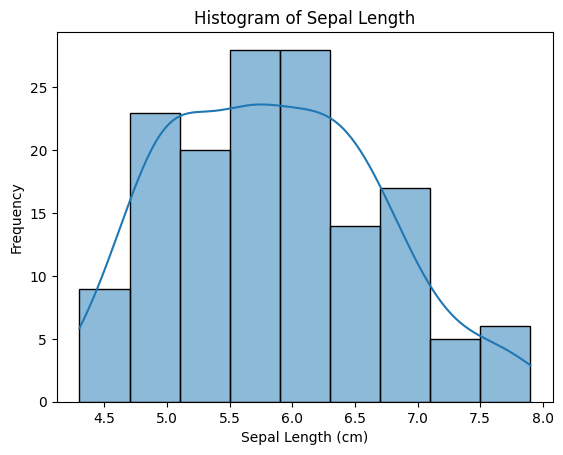

In [ ]:
# Create a histogram to visualize the distribution
sns.histplot(iris['sepal_length'], kde=True)
plt.title('Histogram of Sepal Length')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Frequency')
plt.show()


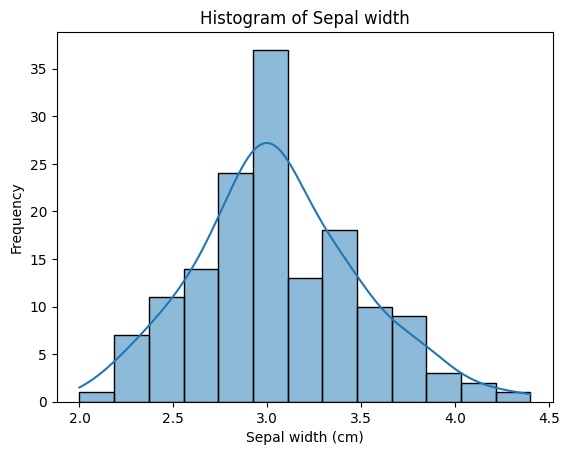

In [ ]:
# Create a histogram to visualize the distribution
sns.histplot(iris['sepal_width'], kde=True)
plt.title('Histogram of Sepal width')
plt.xlabel('Sepal width (cm)')
plt.ylabel('Frequency')
plt.show()

Calculating skewness of petal

In [ ]:
# Calculate skewness
skewness = iris['petal_length'].skew()
print(f'Skewness petal_length: {skewness}')

Skewness petal_length: -0.27488417975101276


In [ ]:
# Calculate skewness
skewness = iris['petal_width'].skew()
print(f'Skewness petal_width: {skewness}')

Skewness petal_width: -0.10296674764898116


Visualizing the distribution

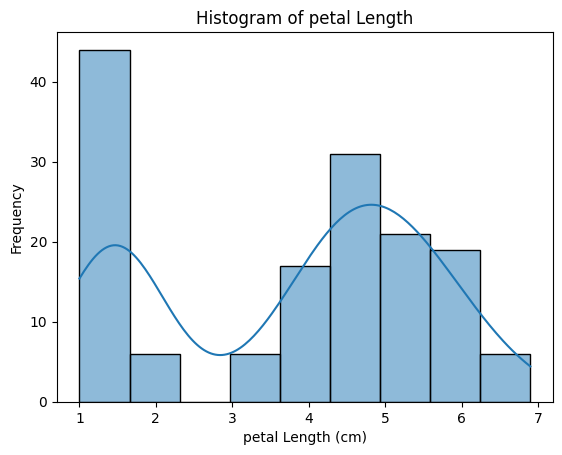

In [ ]:
# Create a histogram to visualize the distribution
sns.histplot(iris['petal_length'], kde=True)
plt.title('Histogram of petal Length')
plt.xlabel('petal Length (cm)')
plt.ylabel('Frequency')
plt.show()

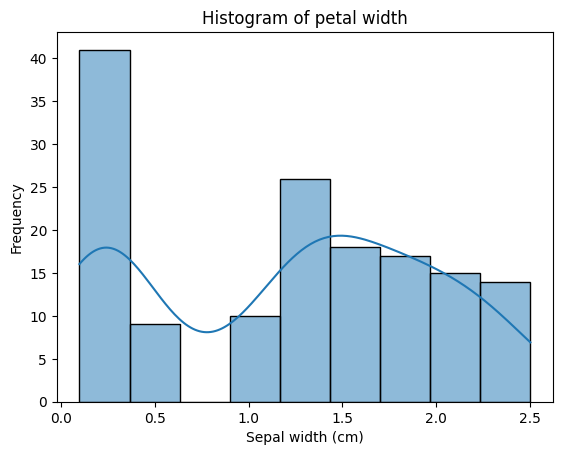

In [ ]:
# Create a histogram to visualize the distribution
sns.histplot(iris['petal_width'], kde=True)
plt.title('Histogram of petal width')
plt.xlabel('Sepal width (cm)')
plt.ylabel('Frequency')
plt.show()

# Multicolinearity

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Simulate data
np.random.seed(42)
n = 100
X1 = np.random.rand(n)
X2 = 0.8 * X1 + 0.2 * np.random.rand(n)  # X2 highly correlated with X1
Y = 2 * X1 + 3 * X2 + np.random.rand(n)

# Create DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})

# Fit regression model
X = sm.add_constant(data[['X1', 'X2']])
model = sm.OLS(data['Y'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     972.7
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           6.56e-65
Time:                        20:48:53   Log-Likelihood:                -17.603
No. Observations:                 100   AIC:                             41.21
Df Residuals:                      97   BIC:                             49.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6111      0.075      8.101      0.0

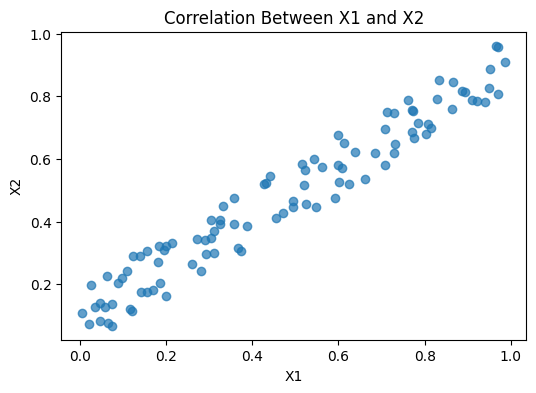

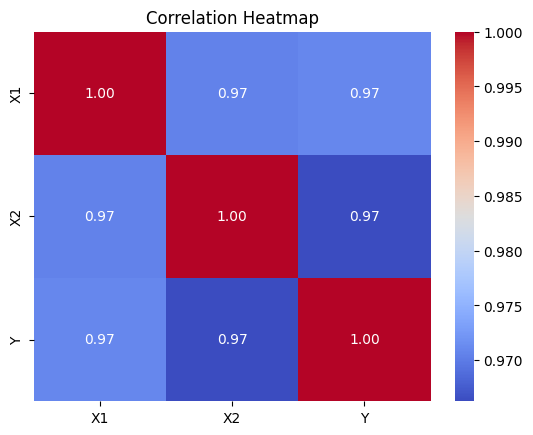

In [ ]:
import seaborn as sns

# Scatter plot showing correlation
plt.figure(figsize=(6, 4))
plt.scatter(data['X1'], data['X2'], alpha=0.7)
plt.title("Correlation Between X1 and X2")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Correlation heatmap
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


  Variable        VIF
0    const   6.628110
1       X1  17.225173
2       X2  17.225173


In [ ]:
cond_number = np.linalg.cond(X)
print("Condition Number:", cond_number)


Condition Number: 26.965003252841584


# Overfitting

Degree 1: Train Error = 247.05, Test Error = 194.96
Degree 2: Train Error = 14.52, Test Error = 10.38
Degree 15: Train Error = 13.52, Test Error = 10.16


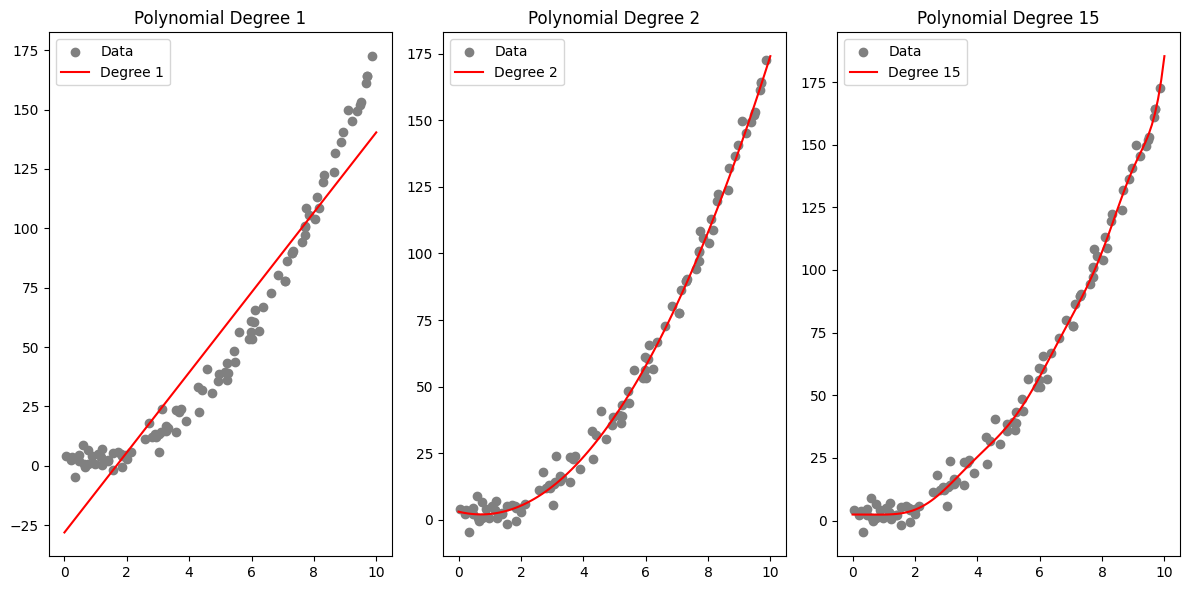

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Simulated data
np.random.seed(42)
X = np.sort(np.random.rand(100, 1) * 10, axis=0)
y = 2 * X**2 - 3 * X + 4 + np.random.normal(0, 4, X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models
degrees = [1, 2, 15]
plt.figure(figsize=(12, 6))
for i, degree in enumerate(degrees, 1):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_train)
    model = LinearRegression().fit(X_poly, y_train)

    # Predictions
    X_test_poly = poly.transform(X_test)
    X_plot = np.linspace(0, 10, 100).reshape(-1, 1)
    y_plot = model.predict(poly.transform(X_plot))

    plt.subplot(1, 3, i)
    plt.scatter(X, y, color='gray', label='Data')
    plt.plot(X_plot, y_plot, color='red', label=f'Degree {degree}')
    plt.title(f'Polynomial Degree {degree}')
    plt.legend()

    # Metrics
    train_error = mean_squared_error(y_train, model.predict(poly.transform(X_train)))
    test_error = mean_squared_error(y_test, model.predict(X_test_poly))
    print(f"Degree {degree}: Train Error = {train_error:.2f}, Test Error = {test_error:.2f}")

plt.tight_layout()
plt.show()


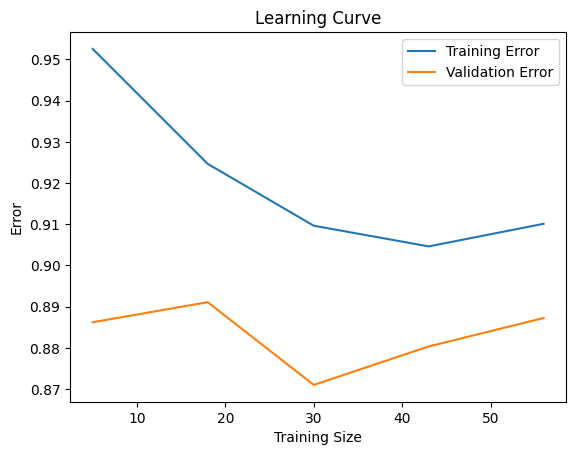

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X_train, y_train, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Error')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Error')
plt.legend()
plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.show()


In [ ]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0).fit(X_train, y_train)
lasso = Lasso(alpha=0.1).fit(X_train, y_train)
